# Deep Hedging AI
### Convegence to Black & Scholes Delta

Hans Buehler, January 2nd, 2023


Deep Hedging AI says hello  ... Tensorflow version 2.7.0


## Deep Hedging in Black \& Scholes World

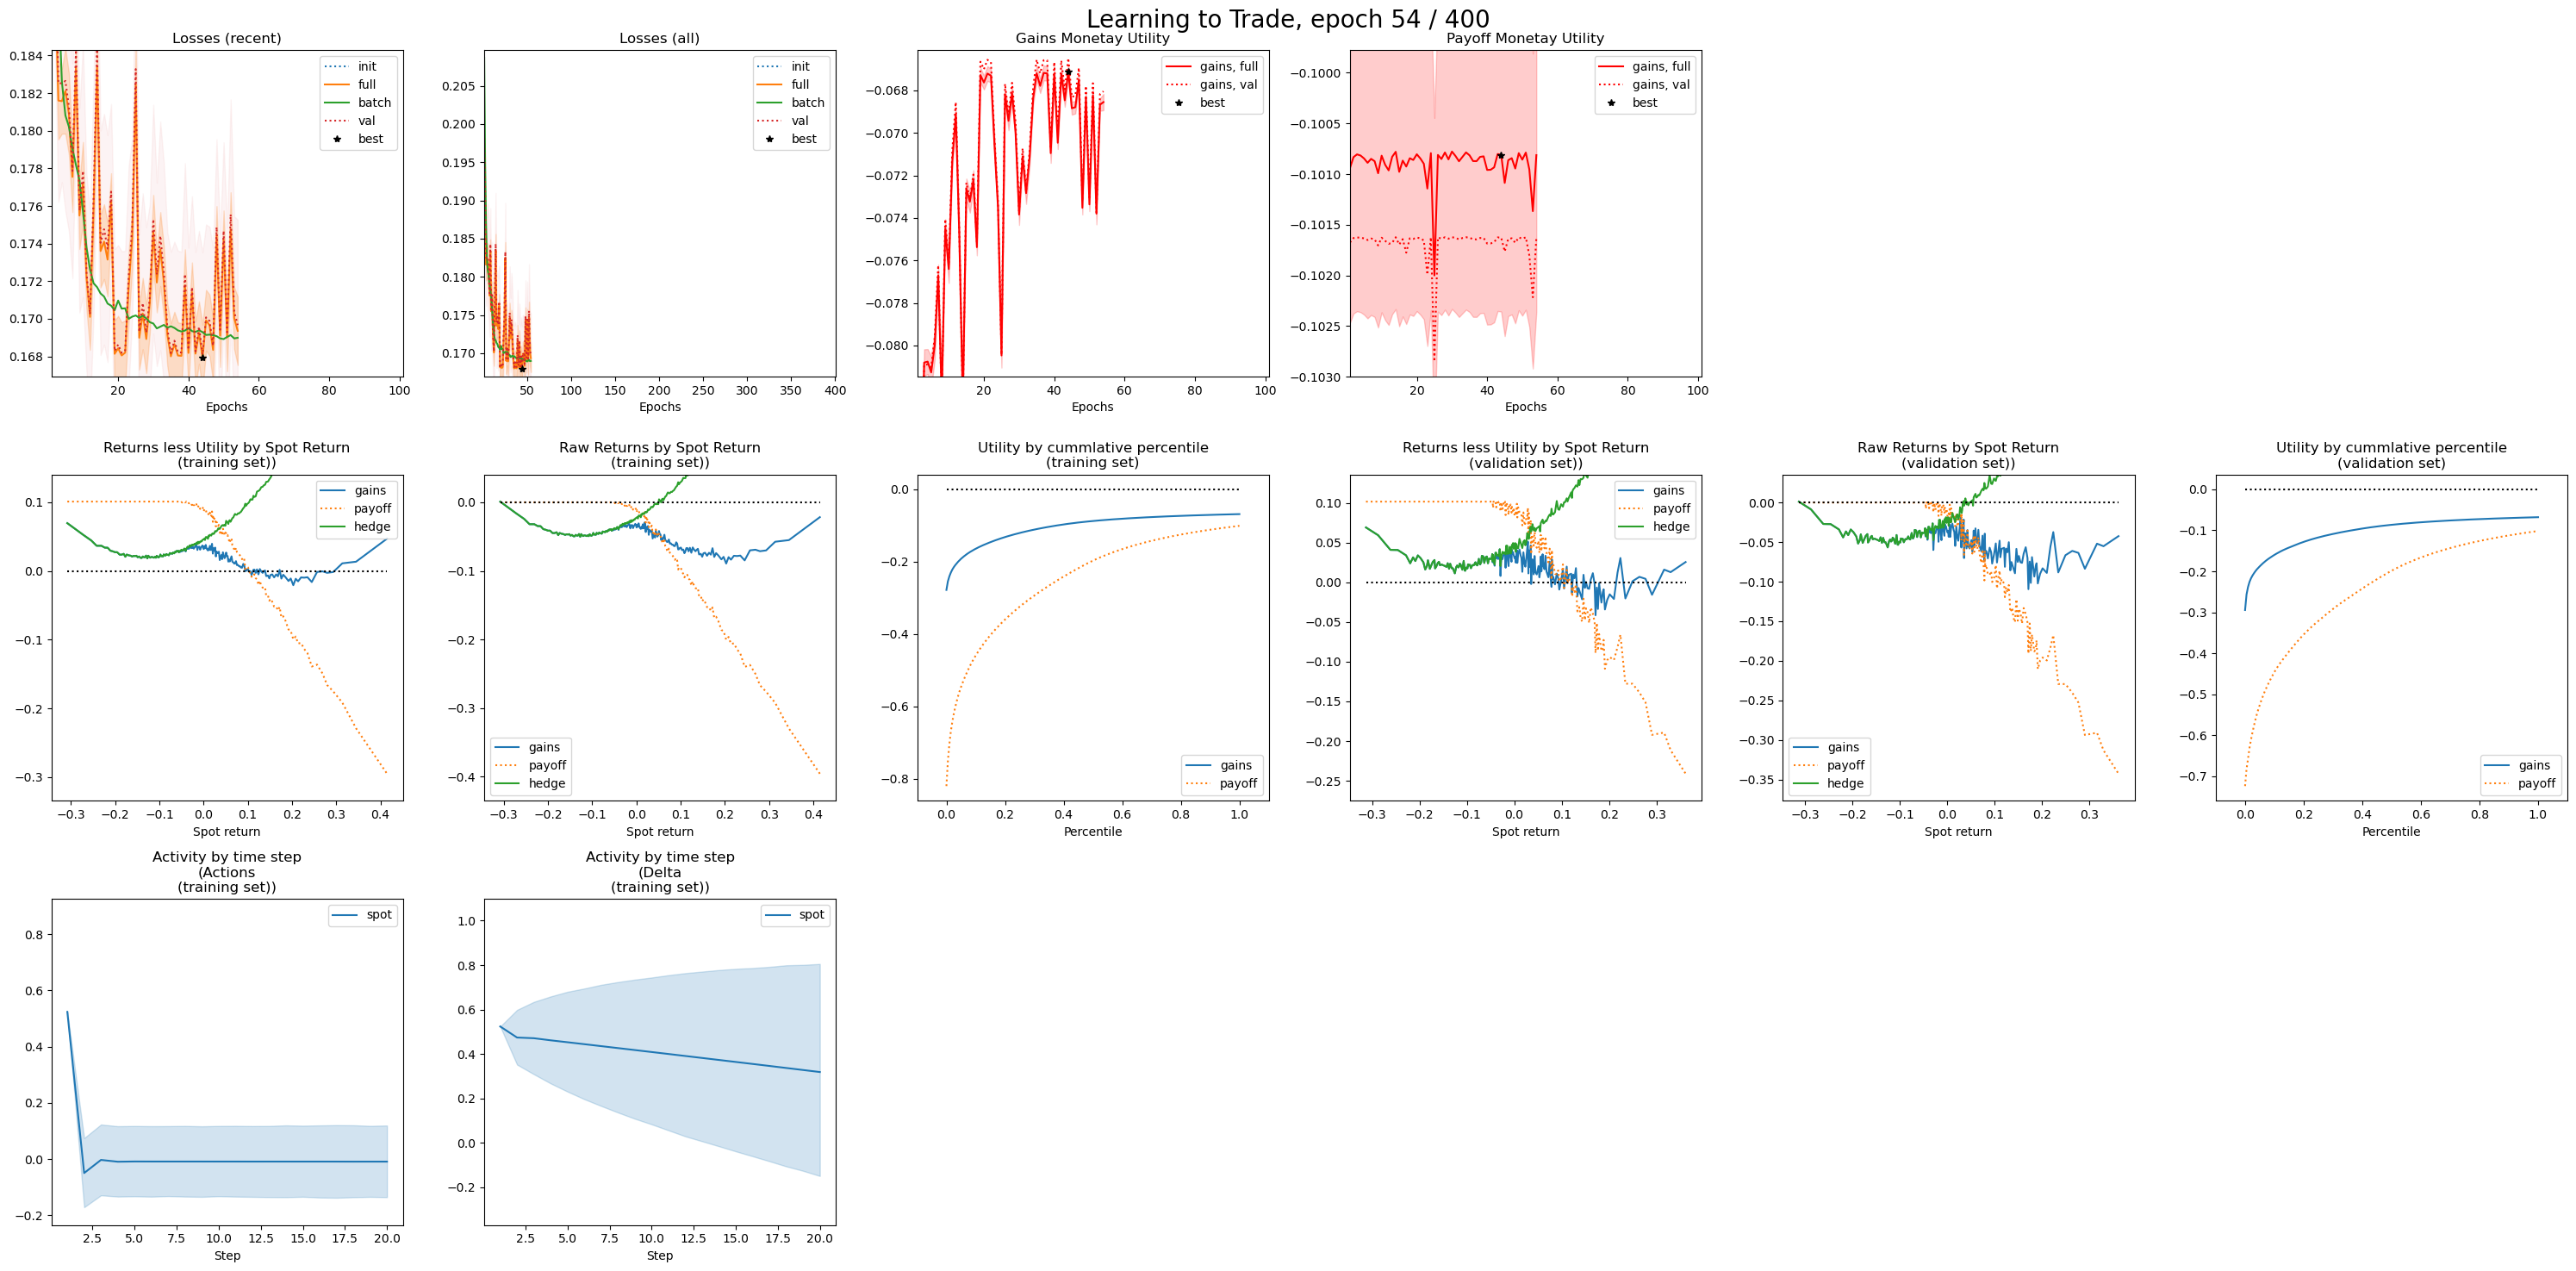

Training 54/400 epochs; 10000 samples; 1000 validation samples batch size 32 | initial loss 1.01947 (0.0155775), full 0.169362 (0.00182151), best 0.167921 (0.0155775), batch 0.168992, val 0.169669 (0.00560152). Best epoch 43 | time elapsed 5:45; estimated time remaining 37:00                         

In [ ]:
"""
When working on the code base, activate below code:

import imp
import deephedging.base as base
imp.reload(base)
import deephedging.world as world
imp.reload(world)
import deephedging.agents as agents
imp.reload(agents)
import deephedging.objectives as objectives
imp.reload(objectives)
import deephedging.gym as gym
imp.reload(gym)
import deephedging.trainer as trainer
imp.reload(trainer)
"""

print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import numpy as np

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
config.world.rvol = 0.2    # 20% volatility
config.world.drift = 0.1    # zero drift
config.world.cost_s = 0.
#config.world.dt = 1./50.
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.  
config.gym.agent.network.depth = 5
config.gym.agent.network.width = 40
config.gym.agent.network.activation = "softplus"
#config.gym.agent.features = []#'spot', 'time_left', 'sqrt_time_left' ]
# trainer
#config.trainer.train.optimizer = "adam"
config.trainer.train.batch_size = None
config.trainer.train.epochs = 400
config.trainer.visual.epoch_refresh = 1
config.trainer.visual.time_refresh = 10
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in Black \& Scholes World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=1000)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()


In [ ]:
from deephedging.base import npCast, perct_exp
from cdxbasics.dynaplot import figure
import numpy as np
import math as math
from scipy.stats import norm

# load data from the training set
spot    = npCast( world.data.features.per_step.spot )
deltas  = npCast( r.deltas )[:,:,0]   # only one asset
actions = npCast( r.actions )[:,:,0]   # only one asset
hedges  = npCast( world.data.market.hedges )[:,:,0]

assert deltas.shape == spot.shape, "Error: expected 'spots' and 'deltas' to have same dimension. Found %s and %s" % (spot.shape,deltas.shape)
assert actions.shape == spot.shape, "Error: expected 'spots' and 'actions' to have same dimension. Found %s and %s" % (spot.shape,actions.shape)
assert hedges.shape == spot.shape, "Error: expected 'spots' and 'hedges' to have same dimension. Found %s and %s" % (spot.shape,hedges.shape)

# load data for BS computation
dt       = 1./50. #config.world("dt")
vol      = config.world("rvol")
drift    = config.world("drift")

# prep spot plotting
bins          = 20
nSpots        = spot.shape[0]
spotsT        = np.sort( spot[:,-1] )
lohi          = perct_exp( spotsT, 0.01, .99 )
binBnd        = np.linspace( lohi[0], lohi[1], bins+1, endpoint=True )
binMid        = 0.5 *( binBnd[1:] + binBnd[:-1] )

def spot_histogram( spots_t ):
    res = np.zeros((bins))
    n   = 0
    for i in range(bins):
        _ = spots_t[ spots_t >= binBnd[i] ]
        _ = _[ _<binBnd[i+1] ]
        c      = np.sum(_)
        res[i] = float(c)
        n      += c
    res = res/float(n)
    return res

delta_bins = 100

# start plotting
fig_any = figure()
plt_spots = fig_any.add_subplot()
plt_spots.set_title("Spot distribution in t")

plt_hedges = fig_any.add_subplot()
plt_hedges.set_title("Hedge Returns")

fig_deltas = figure()

time_steps = deltas.shape[1]

for j in range(time_steps):

    # sort by spot at j, and compute BS refernece
    ixs       = np.argsort( spot[:,j] )
    spot_t    = spot[ixs,j]
    delta_t   = deltas[ixs,j]
    hedges_t  = hedges[ixs,j]
    t         = float(j) * dt
    res_t     = float(time_steps-j) * dt 
    # compute averages over sample data
    dbin_ixs    = np.linspace(0,nSpots,delta_bins+1,endpoint=True,dtype=np.int32)
    dbin_spot_t = np.array([ np.mean(spot_t[ dbin_ixs[i]:dbin_ixs[i+1]]) for i in range(delta_bins) ])
    dbin_dlta_t = np.array([ np.mean(delta_t[ dbin_ixs[i]:dbin_ixs[i+1]]) for i in range(delta_bins) ])
    dbin_hdge_t = np.array([ np.mean(hedges_t[ dbin_ixs[i]:dbin_ixs[i+1]]) for i in range(delta_bins) ])
                           
    # BS
    d1            = ( np.log(dbin_spot_t) + ( drift + 0.5 * vol * vol ) * res_t ) / math.sqrt( res_t * vol * vol )
    bin_bsdelta_t = norm.cdf(d1)

    # plot spot
    plt_spots.plot( binMid, spot_histogram(spot_t), color=(float(j+1)/float(time_steps), 0.1, 0.1), label="%g days" % (t*255) )

    # plot deltas
    plt = fig_deltas.add_subplot()
    plt.plot( spot_t, delta_t, "-" if j>0 else "o", label="model", color=(0.,0.,1.), alpha=0.3)
    plt.plot( dbin_spot_t, dbin_dlta_t, "-" if j>0 else "o", label="avg model", color=(0.,0.,0.5))
    plt.plot( dbin_spot_t, bin_bsdelta_t,  "-" if j>0 else "o", label="black scholes", color=(0.8,0.,0.))
    plt.set_title("Delta %g days" % (t*255))
    if j == time_steps-1:
        plt.legend()

    # plot hedges
    plt_hedges.plot( dbin_spot_t, dbin_hdge_t, color=(0.7, float(j+1)/float(time_steps), 0.7) )
        
fig_any.render()
fig_any.close()

fig_deltas.render()
fig_deltas.close()
    

    